C:\Users\vansh\AppData\Local\Temp\ipykernel_15224\2560202736.py:21: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  sales_data = pd.read_sql(query, connection, parse_dates=['date'], index_col='date')


K-NN RMSE: 124.28749491736632, MAE: 106.43406134969325


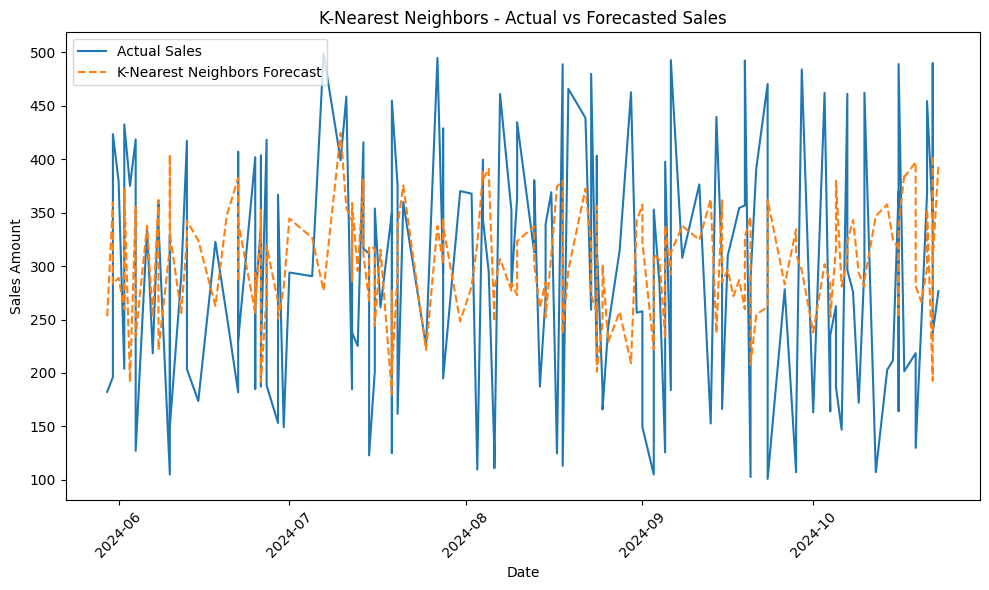

Decision Tree RMSE: 162.8655416211361, MAE: 136.55920245398775


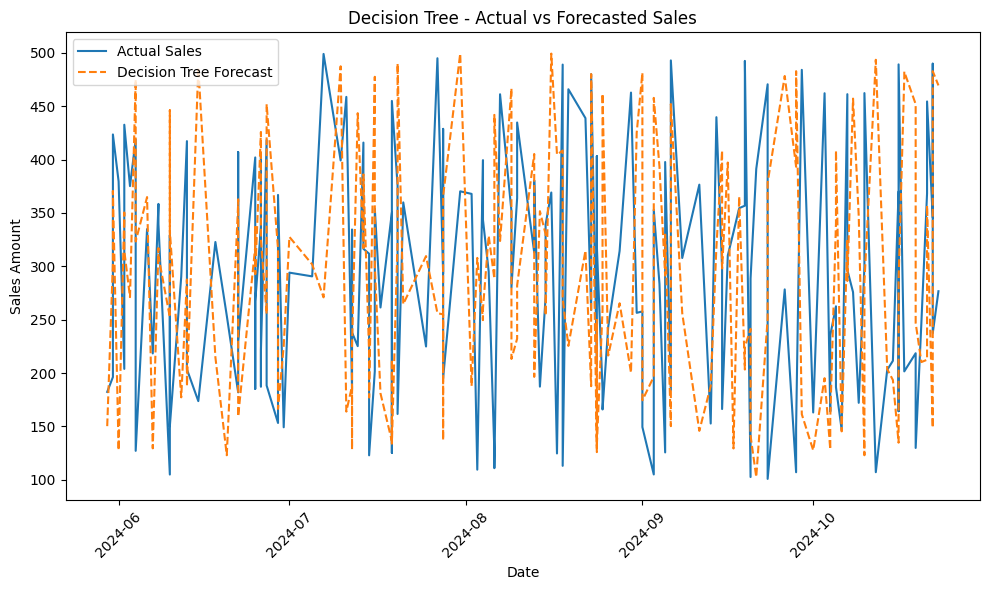

Random Forest RMSE: 137.82455861023885, MAE: 115.88598444785278


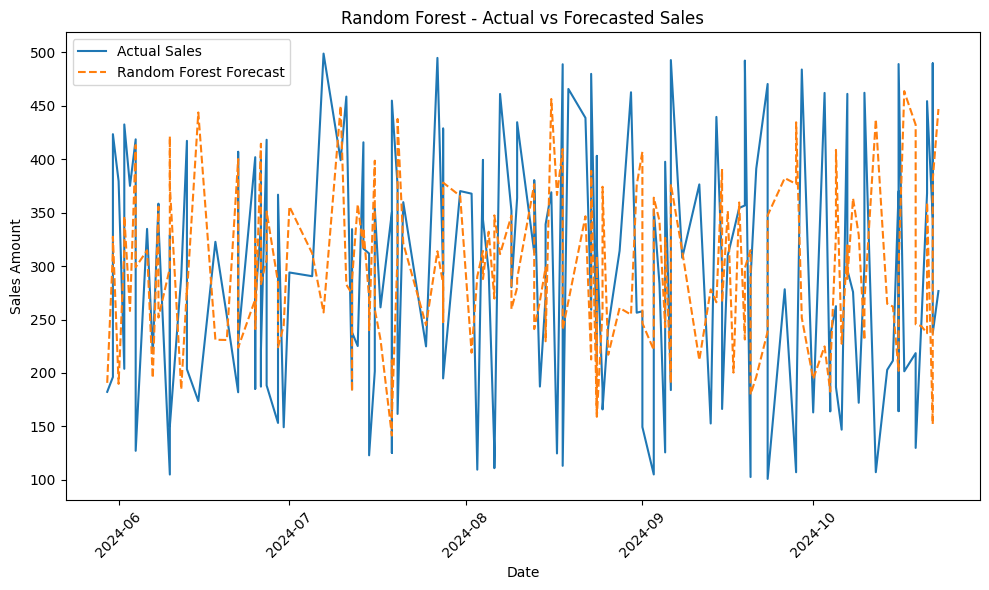

c:\Users\vansh\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\vansh\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\vansh\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\vansh\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the 

SARIMA RMSE: 119.53244954435023, MAE: 102.9153584260077


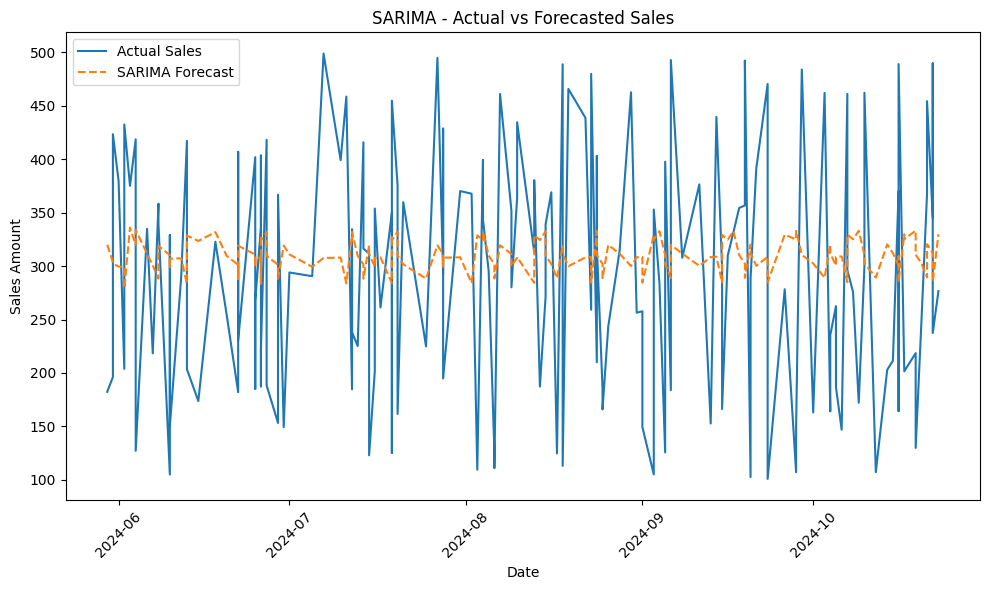


Model Comparison:
K-NN RMSE: 124.28749491736632, MAE: 106.43406134969325
Decision Tree RMSE: 162.8655416211361, MAE: 136.55920245398775
Random Forest RMSE: 137.82455861023885, MAE: 115.88598444785278
SARIMA RMSE: 119.53244954435023, MAE: 102.9153584260077


In [1]:
import pandas as pd
import numpy as np
import mysql.connector
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Connect to MySQL and retrieve data
def fetch_sales_data():
    connection = mysql.connector.connect(
        host='localhost',
        user='root',
        password='7017',
        database='majorProject'
    )
    query = "SELECT sale_date AS date, sales_amount FROM sales_data ORDER BY sale_date"
    sales_data = pd.read_sql(query, connection, parse_dates=['date'], index_col='date')
    connection.close()
    return sales_data

# Prepare the data (convert time series into supervised learning)
def prepare_data(df, n_lags=30):
    df['sales_amount_lag'] = df['sales_amount'].shift(n_lags)
    df.dropna(inplace=True)
    X = df[['sales_amount_lag']]
    y = df['sales_amount']
    return X, y

# Train and evaluate models
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    return rmse, mae, y_test, y_pred

# SARIMA model evaluation
def evaluate_sarima(train, test):
    model = sm.tsa.SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
    model_fit = model.fit(disp=False)
    y_pred = model_fit.forecast(steps=len(test))
    rmse = np.sqrt(mean_squared_error(test, y_pred))
    mae = mean_absolute_error(test, y_pred)
    return rmse, mae, test, y_pred

# Plot forecasted vs actual values
def plot_results(y_test, y_pred, model_name):
    plt.figure(figsize=(10, 6))
    plt.plot(y_test.index, y_test, label='Actual Sales')
    plt.plot(y_test.index, y_pred, label=f'{model_name} Forecast', linestyle='--')
    plt.title(f'{model_name} - Actual vs Forecasted Sales')
    plt.xlabel('Date')
    plt.ylabel('Sales Amount')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Main code
if __name__ == "__main__":
    # Fetch sales data from MySQL
    sales_data = fetch_sales_data()

    # Prepare the data for supervised learning
    X, y = prepare_data(sales_data)

    # Split the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    # 1. K-Nearest Neighbors
    knn_model = KNeighborsRegressor(n_neighbors=5)
    knn_rmse, knn_mae, y_test_knn, y_pred_knn = evaluate_model(knn_model, X_train, X_test, y_train, y_test)
    print(f"K-NN RMSE: {knn_rmse}, MAE: {knn_mae}")
    plot_results(y_test_knn, y_pred_knn, "K-Nearest Neighbors")

    # 2. Decision Tree Regressor
    dt_model = DecisionTreeRegressor(random_state=42)
    dt_rmse, dt_mae, y_test_dt, y_pred_dt = evaluate_model(dt_model, X_train, X_test, y_train, y_test)
    print(f"Decision Tree RMSE: {dt_rmse}, MAE: {dt_mae}")
    plot_results(y_test_dt, y_pred_dt, "Decision Tree")

    # 3. Random Forest Regressor
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_rmse, rf_mae, y_test_rf, y_pred_rf = evaluate_model(rf_model, X_train, X_test, y_train, y_test)
    print(f"Random Forest RMSE: {rf_rmse}, MAE: {rf_mae}")
    plot_results(y_test_rf, y_pred_rf, "Random Forest")

    # 4. SARIMA Model
    train_data = sales_data[:int(len(sales_data) * 0.8)]
    test_data = sales_data[int(len(sales_data) * 0.8):]
    sarima_rmse, sarima_mae, y_test_sarima, y_pred_sarima = evaluate_sarima(train_data['sales_amount'], test_data['sales_amount'])
    print(f"SARIMA RMSE: {sarima_rmse}, MAE: {sarima_mae}")
    plot_results(test_data['sales_amount'], y_pred_sarima, "SARIMA")

    # Compare the performance of all models
    print("\nModel Comparison:")
    print(f"K-NN RMSE: {knn_rmse}, MAE: {knn_mae}")
    print(f"Decision Tree RMSE: {dt_rmse}, MAE: {dt_mae}")
    print(f"Random Forest RMSE: {rf_rmse}, MAE: {rf_mae}")
    print(f"SARIMA RMSE: {sarima_rmse}, MAE: {sarima_mae}")


C:\Users\vansh\AppData\Local\Temp\ipykernel_15224\3382187390.py:21: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  sales_data = pd.read_sql(query, connection, parse_dates=['sale_date'])


K-NN RMSE: 126.31359593801808, MAE: 106.55934911242603


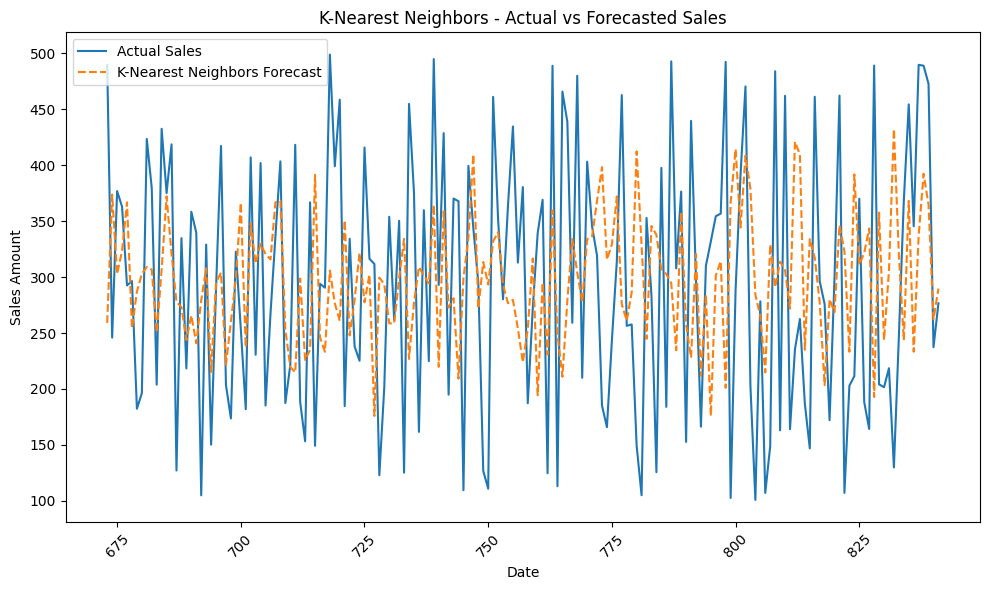

Decision Tree RMSE: 169.1722701286277, MAE: 140.2862130177515


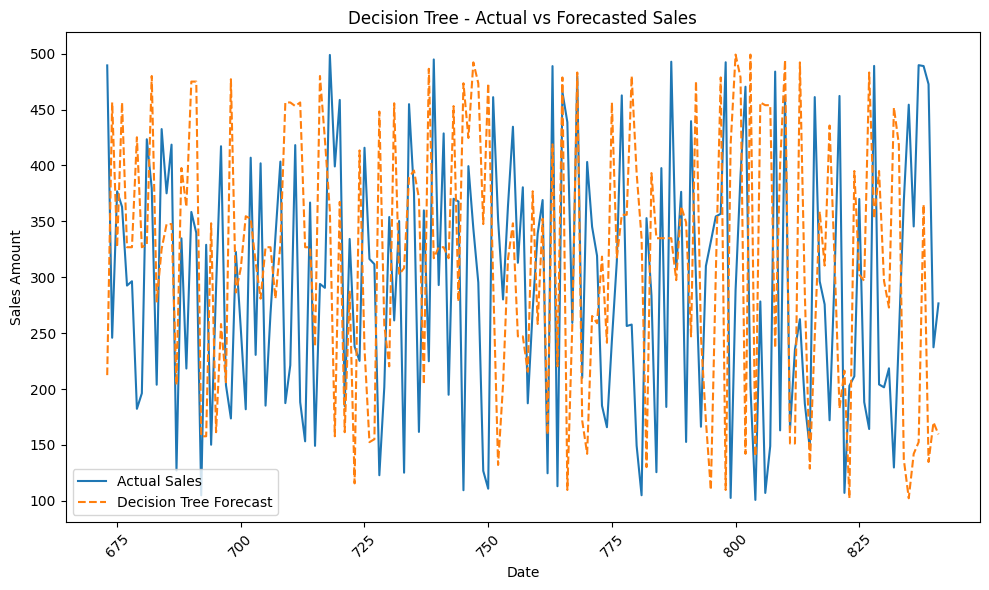

Random Forest RMSE: 122.80643923302844, MAE: 104.90321893491127


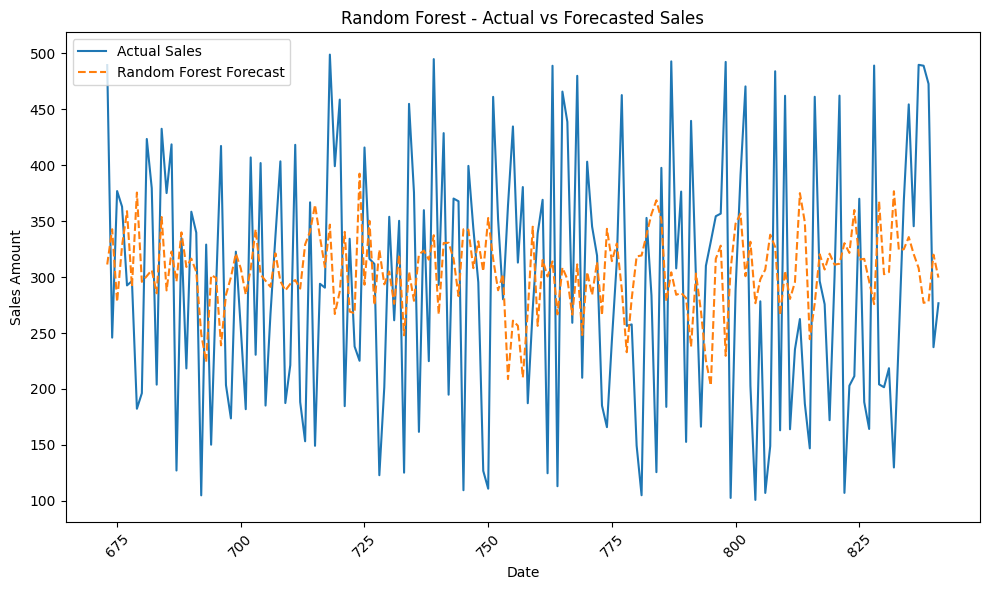

SARIMA RMSE: 117.65900256837362, MAE: 100.90021898906932


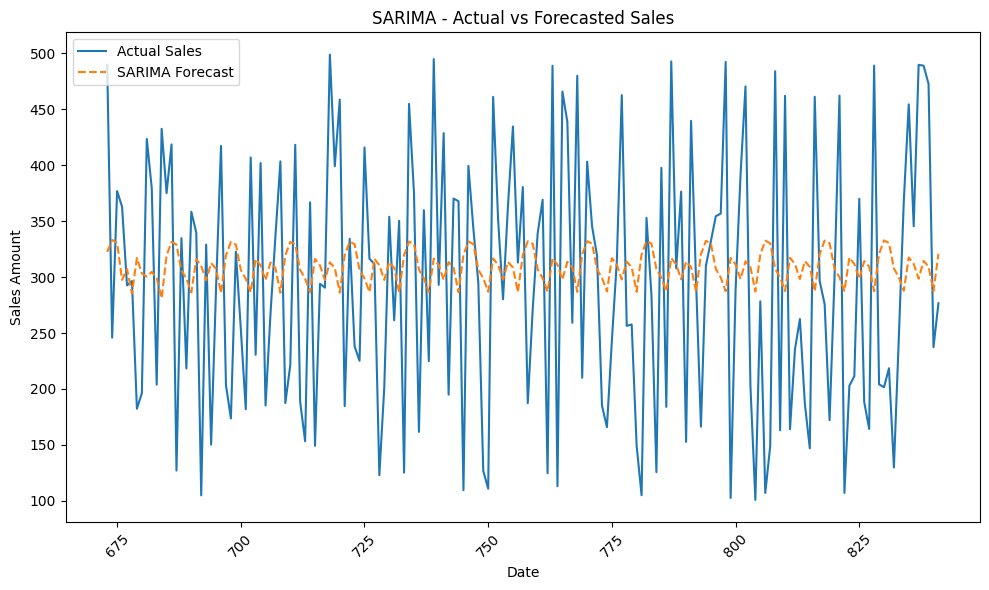


Model Comparison:
K-NN RMSE: 126.31359593801808, MAE: 106.55934911242603
Decision Tree RMSE: 169.1722701286277, MAE: 140.2862130177515
Random Forest RMSE: 122.80643923302844, MAE: 104.90321893491127
SARIMA RMSE: 117.65900256837362, MAE: 100.90021898906932


In [4]:
import pandas as pd
import numpy as np
import mysql.connector
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Connect to MySQL and retrieve data
def fetch_sales_data():
    connection = mysql.connector.connect(
        host='localhost',
        user='root',
        password='7017',
        database='majorProject'
    )
    query = "SELECT * FROM sales_data ORDER BY sale_date"  # Select all columns
    sales_data = pd.read_sql(query, connection, parse_dates=['sale_date'])
    connection.close()
    return sales_data

# Prepare the data
def prepare_data(df):
    # Remove or transform the date column
    df['sale_date'] = pd.to_datetime(df['sale_date'])  # Ensure it's datetime
    df['year'] = df['sale_date'].dt.year
    df['month'] = df['sale_date'].dt.month
    df['day'] = df['sale_date'].dt.day
    df.drop(columns=['sale_date'], inplace=True)  # Drop the original date column
    
    # Convert categorical features to numeric using one-hot encoding
    df = pd.get_dummies(df, drop_first=True)  # This converts categorical variables to dummy/indicator variables
    
    X = df.drop(columns=['sales_amount'])  # Use all columns except 'sales_amount' as features
    y = df['sales_amount']  # Target variable, the column you want to predict
    return X, y

# Train and evaluate models
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    return rmse, mae, y_test, y_pred

# SARIMA model evaluation
def evaluate_sarima(train, test):
    model = sm.tsa.SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
    model_fit = model.fit(disp=False)
    y_pred = model_fit.forecast(steps=len(test))
    rmse = np.sqrt(mean_squared_error(test, y_pred))
    mae = mean_absolute_error(test, y_pred)
    return rmse, mae, test, y_pred

# Plot forecasted vs actual values
def plot_results(y_test, y_pred, model_name):
    plt.figure(figsize=(10, 6))
    plt.plot(y_test.index, y_test, label='Actual Sales')
    plt.plot(y_test.index, y_pred, label=f'{model_name} Forecast', linestyle='--')
    plt.title(f'{model_name} - Actual vs Forecasted Sales')
    plt.xlabel('Date')
    plt.ylabel('Sales Amount')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Main code
if __name__ == "__main__":
    # Fetch sales data from MySQL
    sales_data = fetch_sales_data()

    # Prepare the data for supervised learning
    X, y = prepare_data(sales_data)

    # Split the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    # 1. K-Nearest Neighbors
    knn_model = KNeighborsRegressor(n_neighbors=5)
    knn_rmse, knn_mae, y_test_knn, y_pred_knn = evaluate_model(knn_model, X_train, X_test, y_train, y_test)
    print(f"K-NN RMSE: {knn_rmse}, MAE: {knn_mae}")
    plot_results(y_test_knn, y_pred_knn, "K-Nearest Neighbors")

    # 2. Decision Tree Regressor
    dt_model = DecisionTreeRegressor(random_state=42)
    dt_rmse, dt_mae, y_test_dt, y_pred_dt = evaluate_model(dt_model, X_train, X_test, y_train, y_test)
    print(f"Decision Tree RMSE: {dt_rmse}, MAE: {dt_mae}")
    plot_results(y_test_dt, y_pred_dt, "Decision Tree")

    # 3. Random Forest Regressor
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_rmse, rf_mae, y_test_rf, y_pred_rf = evaluate_model(rf_model, X_train, X_test, y_train, y_test)
    print(f"Random Forest RMSE: {rf_rmse}, MAE: {rf_mae}")
    plot_results(y_test_rf, y_pred_rf, "Random Forest")

    # 4. SARIMA Model
    train_data = sales_data[:int(len(sales_data) * 0.8)]
    test_data = sales_data[int(len(sales_data) * 0.8):]
    sarima_rmse, sarima_mae, y_test_sarima, y_pred_sarima = evaluate_sarima(train_data['sales_amount'], test_data['sales_amount'])
    print(f"SARIMA RMSE: {sarima_rmse}, MAE: {sarima_mae}")
    plot_results(test_data['sales_amount'], y_pred_sarima, "SARIMA")

    # Compare the performance of all models
    print("\nModel Comparison:")
    print(f"K-NN RMSE: {knn_rmse}, MAE: {knn_mae}")
    print(f"Decision Tree RMSE: {dt_rmse}, MAE: {dt_mae}")
    print(f"Random Forest RMSE: {rf_rmse}, MAE: {rf_mae}")
    print(f"SARIMA RMSE: {sarima_rmse}, MAE: {sarima_mae}")


C:\Users\vansh\AppData\Local\Temp\ipykernel_15224\3382187390.py:21: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  sales_data = pd.read_sql(query, connection, parse_dates=['sale_date'])


K-NN RMSE: 126.31359593801808, MAE: 106.55934911242603
K-NN Predictions vs Actual:
     Actual Sales  Predicted Sales
673        489.51          259.078
674        245.90          373.716
675        376.92          302.662
676        362.95          323.516
677        292.58          366.866
..            ...              ...
837        489.73          336.900
838        488.92          392.420
839        472.72          364.600
840        237.37          262.312
841        276.63          289.774

[169 rows x 2 columns]


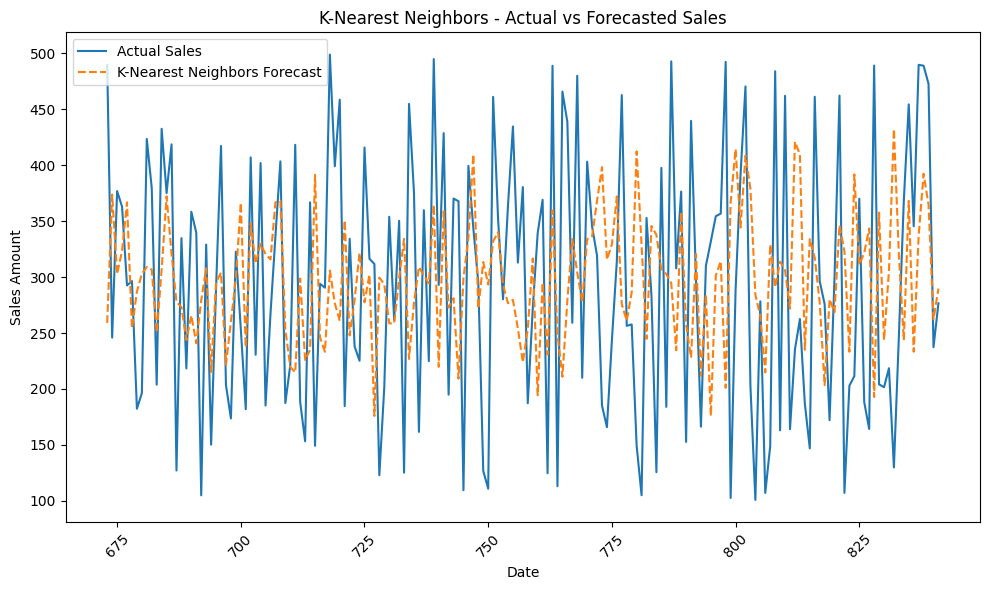

Decision Tree RMSE: 169.1722701286277, MAE: 140.2862130177515
Decision Tree Predictions vs Actual:
     Actual Sales  Predicted Sales
673        489.51           212.46
674        245.90           456.37
675        376.92           326.88
676        362.95           456.37
677        292.58           326.88
..            ...              ...
837        489.73           152.53
838        488.92           365.19
839        472.72           134.79
840        237.37           170.29
841        276.63           159.53

[169 rows x 2 columns]


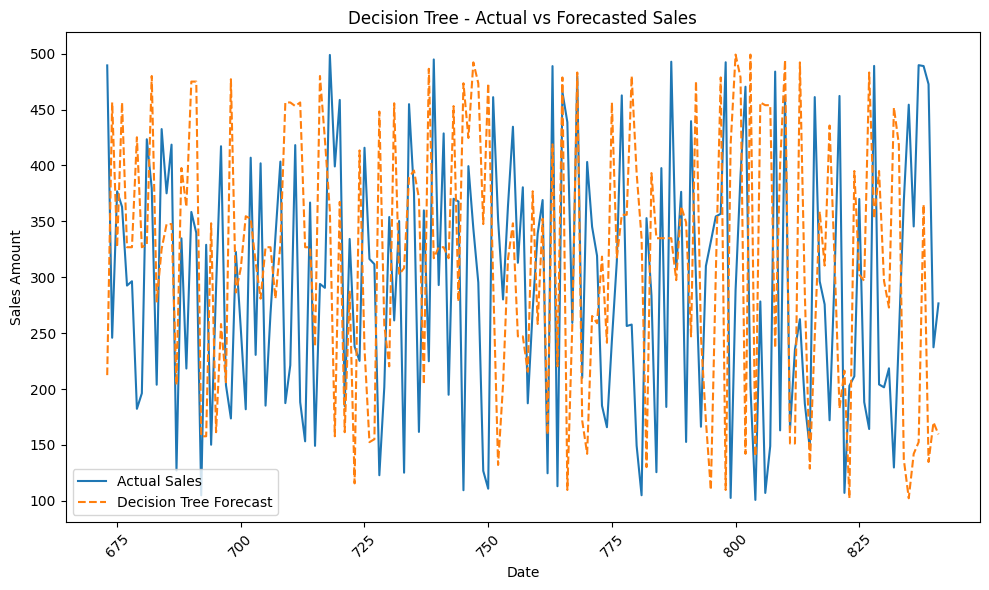

Random Forest RMSE: 122.80643923302844, MAE: 104.90321893491127
Random Forest Predictions vs Actual:
     Actual Sales  Predicted Sales
673        489.51         311.2592
674        245.90         342.7743
675        376.92         277.8532
676        362.95         328.0322
677        292.58         358.9345
..            ...              ...
837        489.73         308.0470
838        488.92         276.9602
839        472.72         278.2146
840        237.37         320.0345
841        276.63         299.5449

[169 rows x 2 columns]


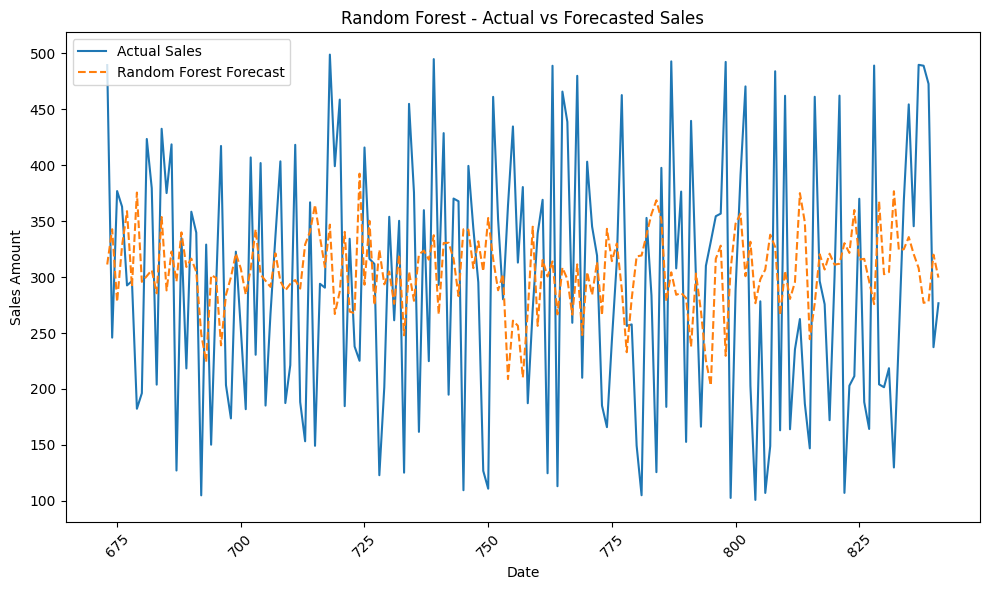

SARIMA RMSE: 117.65900256837362, MAE: 100.90021898906932
SARIMA Predictions vs Actual:
     Actual Sales  Predicted Sales
673        489.51       322.508944
674        245.90       333.282321
675        376.92       330.487320
676        362.95       297.478531
677        292.58       307.226740
..            ...              ...
837        489.73       298.590032
838        488.92       314.472834
839        472.72       309.414015
840        237.37       287.514607
841        276.63       320.842931

[169 rows x 2 columns]


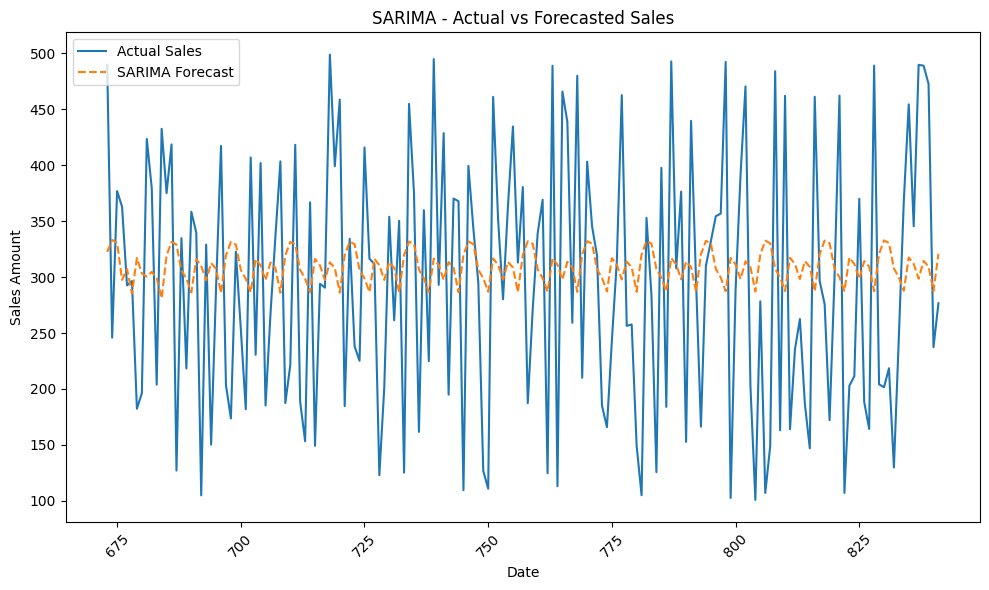


Model Comparison:
K-NN RMSE: 126.31359593801808, MAE: 106.55934911242603
Decision Tree RMSE: 169.1722701286277, MAE: 140.2862130177515
Random Forest RMSE: 122.80643923302844, MAE: 104.90321893491127
SARIMA RMSE: 117.65900256837362, MAE: 100.90021898906932


In [5]:
# Train and evaluate models
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    return rmse, mae, y_test, y_pred

# Main code
if __name__ == "__main__":
    # Fetch sales data from MySQL
    sales_data = fetch_sales_data()

    # Prepare the data for supervised learning
    X, y = prepare_data(sales_data)

    # Split the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    # 1. K-Nearest Neighbors
    knn_model = KNeighborsRegressor(n_neighbors=5)
    knn_rmse, knn_mae, y_test_knn, y_pred_knn = evaluate_model(knn_model, X_train, X_test, y_train, y_test)
    print(f"K-NN RMSE: {knn_rmse}, MAE: {knn_mae}")
    print("K-NN Predictions vs Actual:")
    print(pd.DataFrame({'Actual Sales': y_test_knn, 'Predicted Sales': y_pred_knn}))
    plot_results(y_test_knn, y_pred_knn, "K-Nearest Neighbors")

    # 2. Decision Tree Regressor
    dt_model = DecisionTreeRegressor(random_state=42)
    dt_rmse, dt_mae, y_test_dt, y_pred_dt = evaluate_model(dt_model, X_train, X_test, y_train, y_test)
    print(f"Decision Tree RMSE: {dt_rmse}, MAE: {dt_mae}")
    print("Decision Tree Predictions vs Actual:")
    print(pd.DataFrame({'Actual Sales': y_test_dt, 'Predicted Sales': y_pred_dt}))
    plot_results(y_test_dt, y_pred_dt, "Decision Tree")

    # 3. Random Forest Regressor
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_rmse, rf_mae, y_test_rf, y_pred_rf = evaluate_model(rf_model, X_train, X_test, y_train, y_test)
    print(f"Random Forest RMSE: {rf_rmse}, MAE: {rf_mae}")
    print("Random Forest Predictions vs Actual:")
    print(pd.DataFrame({'Actual Sales': y_test_rf, 'Predicted Sales': y_pred_rf}))
    plot_results(y_test_rf, y_pred_rf, "Random Forest")

    # 4. SARIMA Model
    train_data = sales_data[:int(len(sales_data) * 0.8)]
    test_data = sales_data[int(len(sales_data) * 0.8):]
    sarima_rmse, sarima_mae, y_test_sarima, y_pred_sarima = evaluate_sarima(train_data['sales_amount'], test_data['sales_amount'])
    print(f"SARIMA RMSE: {sarima_rmse}, MAE: {sarima_mae}")
    print("SARIMA Predictions vs Actual:")
    print(pd.DataFrame({'Actual Sales': test_data['sales_amount'], 'Predicted Sales': y_pred_sarima}))
    plot_results(test_data['sales_amount'], y_pred_sarima, "SARIMA")

    # Compare the performance of all models
    print("\nModel Comparison:")
    print(f"K-NN RMSE: {knn_rmse}, MAE: {knn_mae}")
    print(f"Decision Tree RMSE: {dt_rmse}, MAE: {dt_mae}")
    print(f"Random Forest RMSE: {rf_rmse}, MAE: {rf_mae}")
    print(f"SARIMA RMSE: {sarima_rmse}, MAE: {sarima_mae}")
